# 1- Data Reading

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/caption_dataset/caption_dataset.zip" -d "/content/dataset/"


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/dataset/train/train/5499.jpg  
  inflating: /content/dataset/train/train/55.jpg  
  inflating: /content/dataset/train/train/550.jpg  
  inflating: /content/dataset/train/train/5500.jpg  
  inflating: /content/dataset/train/train/5501.jpg  
  inflating: /content/dataset/train/train/5502.jpg  
  inflating: /content/dataset/train/train/5503.jpg  
  inflating: /content/dataset/train/train/5504.jpg  
  inflating: /content/dataset/train/train/5505.jpg  
  inflating: /content/dataset/train/train/5506.jpg  
  inflating: /content/dataset/train/train/5507.jpg  
  inflating: /content/dataset/train/train/5508.jpg  
  inflating: /content/dataset/train/train/5509.jpg  
  inflating: /content/dataset/train/train/551.jpg  
  inflating: /content/dataset/train/train/5510.jpg  
  inflating: /content/dataset/train/train/5511.jpg  
  inflating: /content/dataset/train/train/5512.jpg  
  inflating: /content/dataset/train/train/5513.jpg  
  i

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from PIL import Image


In [4]:
train_df = pd.read_csv("/content/dataset/train.csv")
test_df = pd.read_csv("/content/dataset/test.csv")
sample_df = pd.read_csv("/content/dataset/sample_submission.csv")

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
train_df.head()

Train set shape: (21367, 2)
Test set shape: (3771, 1)


,image_id,caption
0,0,The image features a comic-style panel depicti...
1,1,"Colorful postcard featuring ""Greetings from Ch..."
2,2,Two vending machines display a variety of drin...
3,3,A man speaks at the eGovernment Conference 201...
4,4,A close-up of several silver coins stacked tog...


In [5]:
train_df['caption_length'] = train_df['caption'].apply(lambda x: len(x.split()))
train_df['caption_length'].describe()


,caption_length
count,21367.000000
mean,17.971732
std,2.291874
min,8.000000
25%,16.000000
50%,18.000000
75%,19.000000
max,32.000000


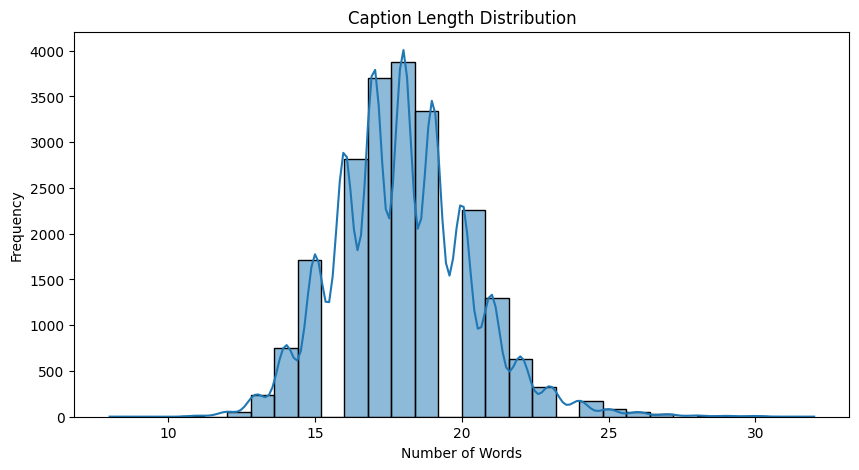

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(train_df['caption_length'], bins=30, kde=True)
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


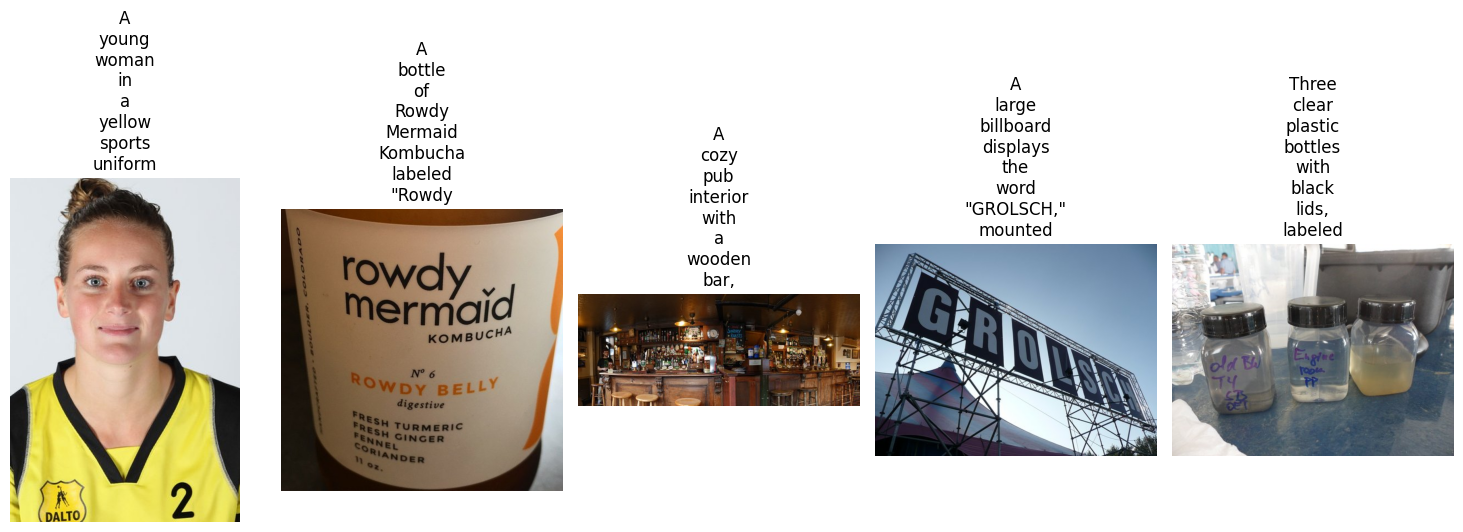

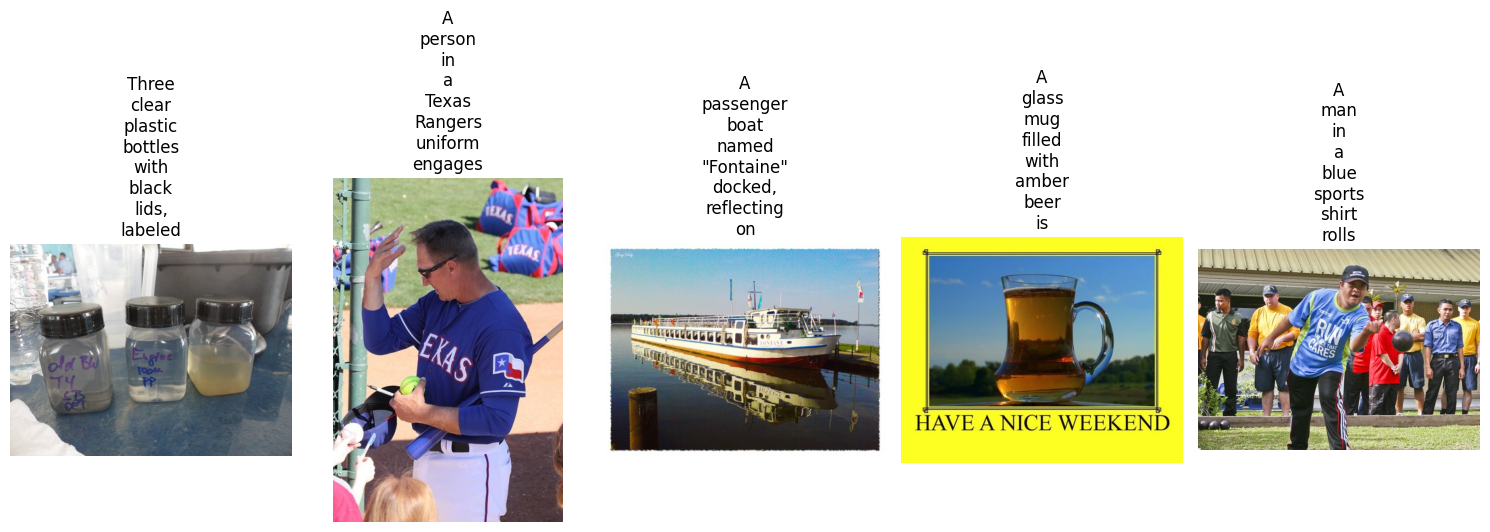

In [7]:
def show_random_examples(df, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        row = df.sample(1).iloc[0]
        img_filename = f"{row['image_id']}.jpg"
        img_path = f"/content/dataset/train/train/{img_filename}"
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        image = Image.open(img_path).convert("RGB")
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title("\n".join(row['caption'].split()[:8]))
    plt.tight_layout()
    plt.show()

show_random_examples(train_df, 5)
show_random_examples(train_df, 5)

In [8]:
print("Unique captions:", train_df['caption'].nunique())
print("Average caption length:", train_df['caption_length'].mean())


Unique captions: 21367
Average caption length: 17.971732110263492


# 2- Data Preprocessing

* Image Preprocessing
* Text Preprocessing


In [9]:
from transformers import Blip2Processor

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

In [10]:
train_df['caption_proc'] = train_df['caption'].apply(lambda x: "<start> " + x.strip() + " <end>")
train_df.head()


,image_id,caption,caption_length,caption_proc
0,0,The image features a comic-style panel depicti...,17,<start> The image features a comic-style panel...
1,1,"Colorful postcard featuring ""Greetings from Ch...",17,"<start> Colorful postcard featuring ""Greetings..."
2,2,Two vending machines display a variety of drin...,17,<start> Two vending machines display a variety...
3,3,A man speaks at the eGovernment Conference 201...,17,<start> A man speaks at the eGovernment Confer...
4,4,A close-up of several silver coins stacked tog...,15,<start> A close-up of several silver coins sta...


In [11]:
from PIL import Image

# example image path
sample_row = train_df.sample(1).iloc[0]
img_path = f"/content/dataset/train/train/{sample_row['image_id']}.jpg"

# load
raw_image = Image.open(img_path).convert('RGB')

# preprocces suitable to BLIP-2
inputs = processor(images=raw_image, return_tensors="pt")
print("Input tensor shape:", inputs['pixel_values'].shape)


Input tensor shape: torch.Size([1, 3, 224, 224])


In [12]:
text_inputs = processor.tokenizer(
    sample_row["caption_proc"],
    padding="max_length",
    max_length=32,
    truncation=True,
    return_tensors="pt"
)

print("Token IDs:", text_inputs['input_ids'])
print("Tokens:", processor.tokenizer.convert_ids_to_tokens(text_inputs['input_ids'][0]))


Token IDs: tensor([[    2, 41552, 13124, 15698,    83,  7304, 16274,    22, 27735,  1653,
          6634,  3672,  2941, 27224,   113,  6476,    15,    10,  2103,     6,
          7513,    30,    10,  4049,     4, 28696,  1397, 15698,     1,     1,
             1,     1]])
Tokens: ['</s>', '<', 'start', '>', 'ĠA', 'Ġbottle', 'Ġlabeled', 'Ġ"', 'Hot', 'ĠCar', 'ls', 'ĠSpecial', 'ĠTe', 'quila', '"', 'Ġsits', 'Ġon', 'Ġa', 'Ġtable', ',', 'Ġaccompanied', 'Ġby', 'Ġa', 'Ġglass', '.', 'Ġ<', 'end', '>', '<pad>', '<pad>', '<pad>', '<pad>']


# 3-Creating Captions

In [13]:
import torch
from transformers import Blip2ForConditionalGeneration

# load model
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    device_map="auto",  # distrubute CPU/GPU for Colab
    torch_dtype=torch.float16  # float16 for Vram
)


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

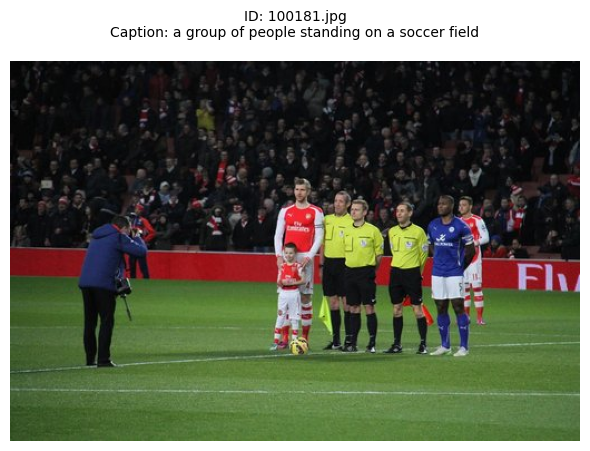

In [19]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch

# GPU/CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Select random image
sample_row = test_df.sample(1).iloc[0]
sample_img_id = str(sample_row['image_id'])
if not sample_img_id.endswith(".jpg"):
    sample_img_id += ".jpg"

img_path = f"/content/dataset/test/test/{sample_img_id}"

# load image
image = Image.open(img_path).convert("RGB")

# Make BLIP-2 ready
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device, dtype=torch.float16) for k, v in inputs.items()}

# Create Caption
with torch.no_grad():
    generated_ids = blip_model.generate(
        **inputs,
        max_new_tokens=30,
        do_sample=False
    )

caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Show
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"ID: {sample_img_id}\nCaption: {caption}", fontsize=10)
plt.tight_layout()
plt.show()


In [20]:
from tqdm import tqdm

In [21]:
submission = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_id = str(row["image_id"])
    if not img_id.endswith(".jpg"):
        img_id += ".jpg"

    img_path = f"/content/dataset/test/test/{img_id}"

    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Image not found or corrupted: {img_path}")
        continue

    # BLIP-2
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device, dtype=torch.float16) for k, v in inputs.items()}

    with torch.no_grad():
        generated_ids = blip_model.generate(
            **inputs,
            max_new_tokens=30,
            do_sample=False  # Greedy decoding
        )

    caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Add to Submission
    submission.append({
        "image_id": img_id,
        "caption": caption
    })


100%|██████████| 3771/3771 [22:28<00:00,  2.80it/s]


In [22]:
# DataFrame and save
submission_df = pd.DataFrame(submission)
submission_df.to_csv("submission.csv", index=False)
submission_df.head()


,image_id,caption
0,100000.jpg,a large billboard with a picture of a bird on ...
1,100001.jpg,a person holding a watch and a knife on a beach\n
2,100002.jpg,a shop with many signs and posters on the wall\n
3,100003.jpg,asus eee pc 1000e review\n
4,100004.jpg,a cross stitch picture with the words blasphim...


In [23]:
!pip install -q sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00


In [26]:
from sentence_transformers import SentenceTransformer
gte_model = SentenceTransformer("thenlper/gte-small")


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
gt_df = pd.read_csv("/content/dataset/train.csv")
pred_df = pd.read_csv("submission.csv")

N = min(len(gt_df), len(pred_df))
gt_captions = gt_df["caption"].values[:N]
pred_captions = pred_df["caption"].values[:N]


In [28]:
gt_embed = gte_model.encode(list(gt_captions), batch_size=64, show_progress_bar=True)
pred_embed = gte_model.encode(list(pred_captions), batch_size=64, show_progress_bar=True)


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

In [29]:
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm
import numpy as np

def calculate_fgd(solution_embed: np.ndarray, submission_embed: np.ndarray) -> float:
    fgd_list = []
    for _idx, (sol_emb_sample, sub_emb_sample) in enumerate(zip(solution_embed, submission_embed)):
        sol_emb_sample_rshaped = sol_emb_sample.reshape((1,384))
        sub_emb_sample_rshaped = sub_emb_sample.reshape((1,384))
        e1 = np.concatenate([sol_emb_sample_rshaped, sol_emb_sample_rshaped])
        e2 = np.concatenate([sub_emb_sample_rshaped, sub_emb_sample_rshaped])

        mu1, sigma1 = e1.mean(axis=0), cov(e1, rowvar=False)
        mu2, sigma2 = e2.mean(axis=0), cov(e2, rowvar=False)

        ssdiff = np.sum((mu1 - mu2)**2.0)
        covmean = sqrtm(sigma1.dot(sigma2))

        if iscomplexobj(covmean):
            covmean = covmean.real

        fgd = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
        fgd_list.append(fgd)

        if _idx % 100 == 0:
            print(f"Processed {_idx} samples", end="\r")

    return float(np.mean(fgd_list))



In [30]:
fgd_score = calculate_fgd(gt_embed, pred_embed)
print(f"\nFinal FGD Score: {fgd_score:.4f}")



Final FGD Score: 0.4732 (Lower is better)
